<a href="https://colab.research.google.com/github/cyber-prags/Starbucks-Delivery-Route-Optimisation/blob/main/Route_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing the necessary libraries

In [ ]:
!pip install osmnx

In [ ]:
!pip install --upgrade ortools


## Import our libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2


## Loading our dataset

In [ ]:
dtf = pd.read_csv('/content/data_stores.csv')

In [ ]:
dtf.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


## For our case, let us consider the example of London

In [ ]:
## Analyzing London
city = "London"

For our Route Optimisation problem, let us consider the columns of **City, Street Address, Latitude and Longitude** as the other columns do not hold much importance

In [ ]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In the next step, we will plot the location of the Starbucks Cafes with the starting cafe being coloured red while the other nodes (destinations) coloured as black

In [ ]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


## Plotting our locations on the map

We see from the above that the starting node/ cafe has co-ordinates 42.99, -81.26

In [ ]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

## Laying the graph of the road network

Next, we use the osmnx library to lay a graph representation of the road network, by specifying a radius of 10km from the starting node

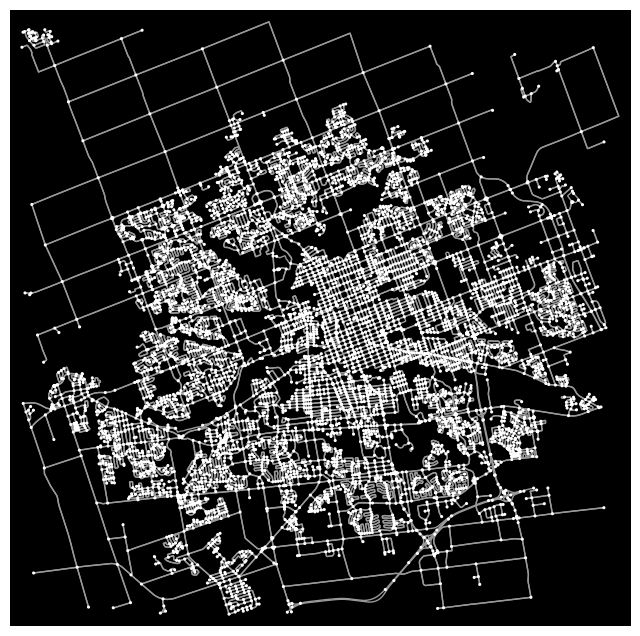

In [ ]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

The next steps would be to calculate the nearest nodes to our starting point and the successive nodes after that

In [ ]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


### Calculating the distance matrix

In [ ]:
def f(a,b):
  try:
    d = nx.shortest_path_length(G, source = a, target=b, method='dijkstra', weight='travel_time')
  except:
    d=np.nan
  return d

distance_matrix = np.asarray([[f(a,b) for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])

distance_matrix = pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.0,562.7,352.8,594.3,498.5,403.3,126.3,393.5,554.8,101.7,514.3,435.1,233.2,198.6,566.3,225.5,521.4,477.2,1036.6,1046.0
324811692,590.0,0.0,211.0,1099.4,950.5,712.1,458.4,871.3,736.6,489.9,402.5,889.8,670.2,403.6,679.8,776.2,120.0,982.3,1310.8,782.0
11756886360,379.0,209.9,0.0,913.0,739.5,578.6,247.4,660.3,550.2,278.9,411.2,703.4,459.2,192.6,580.9,578.2,239.8,795.9,1200.3,914.6
252974916,592.6,1096.3,914.8,0.0,428.6,849.6,704.1,323.6,481.6,665.3,725.6,356.2,500.6,764.0,1075.3,432.7,1025.6,174.5,1301.4,979.4
302754873,498.4,951.5,741.6,429.5,0.0,472.1,572.8,107.2,892.0,513.2,865.1,764.6,348.5,569.2,697.8,394.8,979.4,312.4,923.9,1389.8


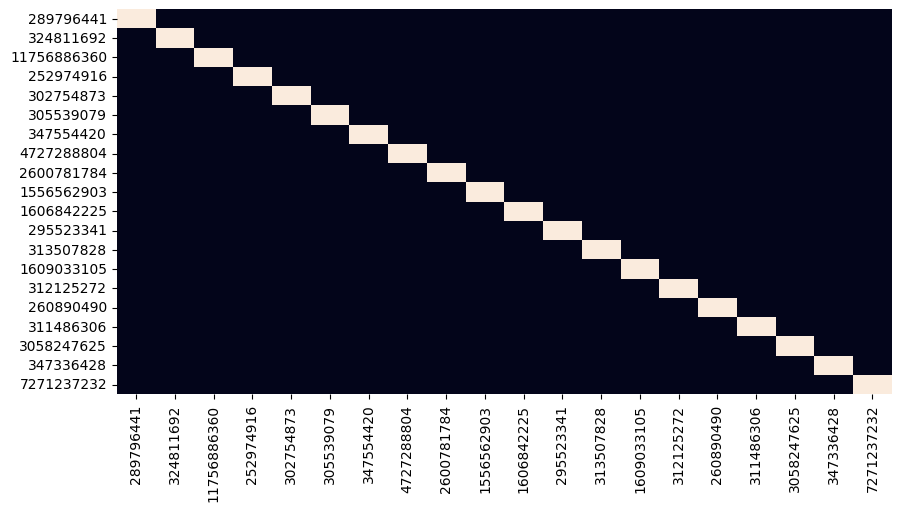

In [ ]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
  heatmap[col]=heatmap[col].apply(lambda x:
                                  0.3 if pd.isnull(x) else
                                  (0.8 if np.isinf(x) else
                                   (0 if x!=0 else 1)))

fig,ax=plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False,ax=ax)
plt.show()

In [ ]:
distance_matrix=distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,563,353,594,499,403,126,394,555,102,514,435,233,199,566,226,521,477,1037,1046
324811692,590,0,211,1099,950,712,458,871,737,490,402,890,670,404,680,776,120,982,1311,782
11756886360,379,210,0,913,740,579,247,660,550,279,411,703,459,193,581,578,240,796,1200,915
252974916,593,1096,915,0,429,850,704,324,482,665,726,356,501,764,1075,433,1026,174,1301,979
302754873,498,952,742,430,0,472,573,107,892,513,865,765,349,569,698,395,979,312,924,1390
305539079,403,640,583,846,470,0,436,524,894,376,867,767,409,410,306,557,744,729,690,1357
347554420,149,456,246,715,571,435,0,466,520,92,479,518,265,92,491,348,424,598,1067,1011
4727288804,391,869,659,322,107,528,466,0,785,406,758,657,241,505,754,288,872,205,980,1283
2600781784,555,732,550,478,887,890,520,782,0,603,361,185,720,577,1002,563,661,633,1523,633
1556562903,169,488,278,668,512,376,92,407,603,0,562,538,206,124,492,335,499,550,1009,1094


## Route Optimisation

For this problem, we are assuming we only have 1 driver that will be delivering supplies to all locations in London

In [ ]:
drivers = 1
lst_nodes = dtf["node"].tolist()
print("start:", start_node, "|total locations to visit:", len(lst_nodes)-1, "|drivers:", drivers)

start: 289796441 |total locations to visit: 19 |drivers: 1


The above gives us information about the starting node, with 19 locations for the single driver to visit

In [ ]:
manager = pywrapcp.RoutingIndexManager(len(lst_nodes),drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

In [ ]:
def get_distance(from_index, to_index):
  return distance_matrix.iloc[from_index, to_index]

distance= model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [ ]:
solution = model.SolveWithParameters(parameters)

index=model.Start(0)
print("Route for Driver:")
route_idx, route_distance = [], 0

while not model.IsEnd(index):
  route_idx.append(manager.IndexToNode(index))
  previous_index = index
  index = solution.Value(model.NextVar(index))

  try:
    route_distance += get_distance(previous_index,index)

  except:
    route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f"Total distance of the route: {round(route_distance/1000,2)} km")
print(f"Nodes visited:" ,len(route_idx))

Route for Driver:
[0, 9, 6, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance of the route: 6.63 km
Nodes visited: 20


In [ ]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 1556562903, 347554420, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [ ]:
def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)

map

In [ ]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df


In [ ]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [ ]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig

In the above cells, we have calculated the best route for the driver to follow to deliver supplies to the Starbuck Cafes within the shortest interval of time.

The total distance covered by the driver is 6.63kms and the order in which he delivers goods to the 20 locations are in the order:

[0, 9, 6, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]